In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erfc
from tqdm.notebook import tqdm
import matplotlib.mlab as mlab
import scipy as sp

from commpy.utilities  import upsample
from optic.models import mzm, photodiode
from optic.metrics import signal_power
from optic.dsp import firFilter, pulseShape, lowPassFIR
from optic.core import parameters
from optic.plot import eyediagram
from optic.amplification import edfaSM, OSA
from numpy.fft import fft

In [2]:
# simulation parameters
SpS = 64

Rs = 10e9 # Symbol rate (for OOK case Rs = Rb)
Tsymb = 1/Rs # Symbol period in seconds
Fs = 1/(Tsymb/SpS) # Signal sampling frequency (samples/second)
Ts = 1/Fs # Sampling period
Fc = 193.1e12

Pi_dBm = 0 # optical signal power at modulator input in dBm

# MZM parameters
Vπ = 2
Vb = -Vπ/2
Pi = 10**(Pi_dBm/10)*1e-3 # optical signal power in W at the MZM input

# generate pseudo-random bit sequence
bitsTx = np.random.randint(2, size=100000)
n = np.arange(0, bitsTx.size)

# map bits to electrical pulses
symbTx = 2*bitsTx-1
symbTx = symbTx/np.sqrt(signal_power(symbTx))

# upsampling
symbolsUp = upsample(symbTx, SpS)

# typical NRZ pulse
pulse = pulseShape('nrz', SpS)
pulse = pulse/max(abs(pulse))

# pulse formatting
sigTx = firFilter(pulse, symbolsUp)

# optical modulation
Ai = np.sqrt(Pi)*np.ones(sigTx.size)
sigTxo = mzm(Ai, sigTx, Vπ, Vb)

In [8]:
param_edfa = parameters()
param_edfa.type  = "AGC"
param_edfa.value = 20
param_edfa.nf    = 5
param_edfa.forPump = {'pump_signal': np.array([200e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.bckPump = {'pump_signal': np.array([000e-3]), 'pump_lambda': np.array([980e-9])}
param_edfa.type = 'AGC'
param_edfa.file = 'C:\\Users\\Adolfo\\Documents\\GitHub\\OptiCommPy\\jupyter\\giles_MP980.dat'
param_edfa.fileunit = 'nm'
param_edfa.gmtc = 'Bessel'

In [4]:
%load_ext line_profiler

In [5]:
%lprun -f edfaSM edfaSM(sigTxo, Fs, Fc, param_edfa)

EDFA: Laço  1

Convergência: 0.000%.



Timer unit: 1e-07 s

Total time: 29.1103 s
File: c:\users\adolfo\documents\github\opticommpy\optic\amplification.py
Function: edfaSM at line 19

Line #      Hits         Time  Per Hit   % Time  Line Contents
    19                                           def edfaSM(Ei, Fs, Fc, param_edfa):
    20                                               # Verify arguments
    21         1         15.0     15.0      0.0      param_edfa.type      = getattr(param_edfa, "type", "AGC")
    22         1          3.0      3.0      0.0      param_edfa.value     = getattr(param_edfa, "value", 20)
    23         1          4.0      4.0      0.0      param_edfa.nf        = getattr(param_edfa, "nf", 5)
    24         1          4.0      4.0      0.0      param_edfa.asep      = getattr(param_edfa, "asep", "X")
    25         1          5.0      5.0      0.0      param_edfa.file      = getattr(param_edfa, "file", "")
    26         1          3.0      3.0      0.0      param_edfa.fileunit  = getattr(param_edf

In [2]:
from optic.tx import simpleWDMTx
from scipy.constants import c, Planck
# Transmitter parameters:
paramTx = parameters()
paramTx.M   = 4             # order of the modulation format
paramTx.Rs  = 40e9          # symbol rate [baud]
paramTx.SpS = 256           # samples per symbol
paramTx.Nbits = 2**12       # total number of bits per polarization
paramTx.pulse = 'rrc'       # pulse shaping filter
paramTx.Ntaps = 1024        # number of pulse shaping filter coefficients
paramTx.alphaRRC = 0.01     # RRC rolloff
paramTx.Pch_dBm = 1         # power per WDM channel [dBm]
paramTx.Nch     = 40        # number of WDM channels
paramTx.Fc      = c/1550e-9 # central optical frequency of the WDM spectrum
paramTx.freqSpac = 200e9    # WDM grid spacing
paramTx.Nmodes = 1          # number of signal modes [2 for polarization multiplexed signals]

Fs = paramTx.Rs*paramTx.SpS
Tw = 1/Fs * (paramTx.Nbits / np.log2(paramTx.M)) * paramTx.SpS
print('Sample rate [THz]: %5.3f' %(1e-12*Fs))
print('Time window [ns]:  %5.3f' %(1e9*Tw))
simOpticalBand = (Fs*(c/paramTx.Fc)**2)/c
print('Comprimento de onda central [nm]: %6.2f' %(1e9*c/paramTx.Fc))
print('Janela de simulação [nm]: %f - [%6.2f nm - %6.2f nm]' 
      %(1e9*simOpticalBand, 1e9*(c/paramTx.Fc-simOpticalBand/2), 1e9*(c/paramTx.Fc+simOpticalBand/2)))
print('Distância entre pontos [GHz]: %f' %(1e-9/Tw))
print('Número total de pontos: %d' %(Fs*Tw))

Sample rate [THz]: 10.240
Time window [ns]:  51.200
Comprimento de onda central [nm]: 1550.00
Janela de simulação [nm]: 82.062104 - [1508.97 nm - 1591.03 nm]
Distância entre pontos [GHz]: 0.019531
Número total de pontos: 524288


In [3]:
# generate WDM signal
sigWDM_Tx, symbTx_, paramTx = simpleWDMTx(paramTx)

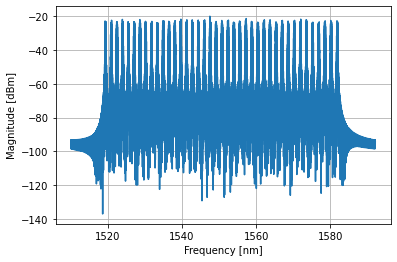

In [4]:
# plot spectrum
OSA(np.squeeze(sigWDM_Tx), Fs, paramTx.Fc)

In [7]:
Eout = edfaSM(sigWDM_Tx, Fs, paramTx.Fc, param_edfa)

EDFA: Laço  1

Convergência: 9.310%.

EDFA: Laço  2

Convergência: -4.664%.



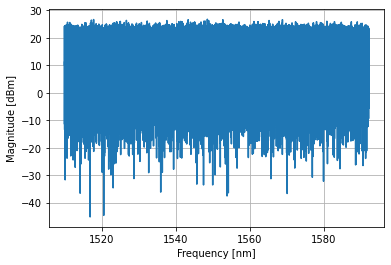

In [9]:
# plot spectrum
OSA(Eout[:,1], Fs, paramTx.Fc)